In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from dataset_func import remap_u_from_sim_grid
from dataset_func import get_X_from_sim_grid
from tools import heatmaps_from_one_sample

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


In [5]:
print(torch.cuda.is_available())  
print(torch.cuda.get_device_name(0))  

True
NVIDIA GeForce RTX 2060


In [6]:
#import data

sim_grid_path = r"C:\Users\Antoine\Documents\master\PA\abacus\sim_plaque\ANNs\datasets\20250331140859"

X = get_X_from_sim_grid(sim_grid_path, ["distances", "plaque_epaisseurs", "materiaux"])
y, invalid_results = remap_u_from_sim_grid(sim_grid_path)
X = np.delete(X, invalid_results, axis=0)

print(f"X shape : {X.shape}")
print(f"y shape : {y.shape}")

0/1680 done
1/1680 done
2/1680 done
3/1680 done
4/1680 done
5/1680 done
6/1680 done
7/1680 done
8/1680 done
9/1680 done
10/1680 done
11/1680 done
12/1680 done
13/1680 done
14/1680 done
15/1680 done
16/1680 done
17/1680 done
18/1680 done
19/1680 done
20/1680 done
21/1680 done
22/1680 done
23/1680 done
24/1680 done
25/1680 done
26/1680 done
27/1680 done
28/1680 done
29/1680 done
30/1680 done
31/1680 done
32/1680 done
33/1680 done
34/1680 done
35/1680 done
36/1680 done
37/1680 done
38/1680 done
39/1680 done
40/1680 done
41/1680 done
42/1680 done
43/1680 done
44/1680 done
45/1680 done
46/1680 done
47/1680 done
48/1680 done
49/1680 done
50/1680 done
51/1680 done
52/1680 done
53/1680 done
54/1680 done
55/1680 done
56/1680 done
57/1680 done
58/1680 done
59/1680 done
60/1680 done
61/1680 done
62/1680 done
63/1680 done
64/1680 done
65/1680 done
66/1680 done
67/1680 done
68/1680 done
69/1680 done
70/1680 done
71/1680 done
72/1680 done
73/1680 done
74/1680 done
75/1680 done
76/1680 done
77/1680 d

In [7]:
y_shape = y.shape
y_transformed = y.reshape(y.shape[0],-1)
print(y_transformed.shape)
y_transformed = y_transformed.reshape(y_shape)
print(y_transformed.shape)

(1373, 576)
(1373, 24, 24)


In [8]:
#normalisation
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_shape = y.shape
y_transformed = y.reshape(y.shape[0],-1)
y_scaled = scaler_y.fit_transform(y_transformed)
y_scaled = y_scaled.reshape(y_shape)


print(f"X_scaled shape : {X_scaled.shape}")
print(f"y_scaled shape : {y_scaled.shape}")

print(X_scaled)

X_scaled shape : (1373, 5)
y_scaled shape : (1373, 24, 24)
[[0.         0.         1.         0.82428115 0.        ]
 [0.         0.         0.39007092 1.         1.        ]
 [0.         0.         0.         0.         0.7       ]
 ...
 [1.         1.         0.39007092 1.         1.        ]
 [1.         1.         0.         0.         0.7       ]
 [1.         1.         0.31914894 0.28753994 0.8       ]]


In [9]:
#to tenseur
X_tenseur = torch.from_numpy(X_scaled.astype(np.float32))
y_tenseur = torch.from_numpy(y_scaled.astype(np.float32))
X_size = X.shape[1]
y_size = y.shape[1]

print(X_tenseur.shape)
print(y_tenseur.shape)

torch.Size([1373, 5])
torch.Size([1373, 24, 24])


In [10]:

# train 0.8, test 0.1, val 0.1
X_train, X_temp, y_train, y_temp = train_test_split(X_tenseur, y_tenseur, test_size=0.2, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.50, shuffle=False)

print(f"X_train shape : {X_train.shape}")
print(f"y_train shape : {y_train.shape}")
print("\n")
print(f"X_val shape : {X_val.shape}")
print(f"y_val shape : {y_val.shape}")
print("\n")
print(f"X_test shape : {X_test.shape}")
print(f"y_test shape : {y_test.shape}")

X_train shape : torch.Size([1098, 5])
y_train shape : torch.Size([1098, 24, 24])


X_val shape : torch.Size([138, 5])
y_val shape : torch.Size([138, 24, 24])


X_test shape : torch.Size([137, 5])
y_test shape : torch.Size([137, 24, 24])


In [11]:
class MLP_displacement(nn.Module):
    def __init__(self, X_size, y_size, hidden_sizes=[64]+[128]*5):
        super(MLP_displacement, self).__init__()
        output_size = y_size ** 2
        self.y_size = y_size
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)

        layers = []
        batchnorms = []
        input_size = X_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            batchnorms.append(nn.BatchNorm1d(hidden_size))
            input_size = hidden_size

        self.hidden_layers = nn.ModuleList(layers)
        self.batchnorms = nn.ModuleList(batchnorms)
        self.output_layer = nn.Linear(input_size, output_size)

    def forward(self, x):
        for layer, bn in zip(self.hidden_layers, self.batchnorms):
        #for layer in self.hidden_layers:
            x = layer(x)
            x = bn(x)
            x = self.activation(x)
            x = self.dropout(x)

        x = self.output_layer(x)
        x = x.view(-1, self.y_size, self.y_size)
        return x

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_displacement = MLP_displacement(X_size, y_size).to(device)

#check device
print(next(model_displacement.parameters()).device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_displacement.parameters(), lr=0.001)

from torch.utils.data import TensorDataset, DataLoader
batch_size = 32 

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


epochs = []
train_losses = []
val_losses = []

num_epochs = 1000
patience = 100  # Number of epochs to wait before stopping if no improvement
best_val_loss = float('inf')  # Initialize with a very high value
epochs_no_improve = 0  # Counter to track epochs without improvement
best_model_weights = None  # To store the best model's weights

for epoch in range(num_epochs):
    # Training Phase
    model_displacement.train()
    epoch_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        # Forward
        pred = model_displacement(batch_X)
        loss = criterion(pred, batch_y)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_X.size(0)  # accumulate total loss

    avg_train_loss = epoch_loss / len(train_loader.dataset)

    # Validation Phase
    model_displacement.eval()  # Set model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # No need to compute gradients during validation
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)            

            pred = model_displacement(batch_X)
            loss = criterion(pred, batch_y)
            val_loss += loss.item() * batch_X.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)

    epochs.append(epoch+1)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_weights = model_displacement.state_dict()  # Save the best model weights
        epochs_no_improve = 0  # Reset counter if improvement
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# Restore the best model weights after training
if best_model_weights is not None:
    model_displacement.load_state_dict(best_model_weights)

cuda:0
Epoch 1/1000 - Train Loss: 1.1513 - Validation Loss: 0.9206
Epoch 2/1000 - Train Loss: 1.0759 - Validation Loss: 0.9143
Epoch 3/1000 - Train Loss: 1.0393 - Validation Loss: 0.9116
Epoch 4/1000 - Train Loss: 1.0305 - Validation Loss: 0.9085
Epoch 5/1000 - Train Loss: 1.0279 - Validation Loss: 0.9205
Epoch 6/1000 - Train Loss: 1.0234 - Validation Loss: 0.9226
Epoch 7/1000 - Train Loss: 1.0222 - Validation Loss: 0.9223
Epoch 8/1000 - Train Loss: 1.0172 - Validation Loss: 0.9435
Epoch 9/1000 - Train Loss: 1.0201 - Validation Loss: 0.9130
Epoch 10/1000 - Train Loss: 1.0146 - Validation Loss: 0.9171
Epoch 11/1000 - Train Loss: 1.0059 - Validation Loss: 0.9162
Epoch 12/1000 - Train Loss: 1.0063 - Validation Loss: 0.9447
Epoch 13/1000 - Train Loss: 1.0092 - Validation Loss: 0.9083
Epoch 14/1000 - Train Loss: 0.9830 - Validation Loss: 0.9733
Epoch 15/1000 - Train Loss: 1.0188 - Validation Loss: 0.9184
Epoch 16/1000 - Train Loss: 1.0055 - Validation Loss: 0.9277
Epoch 17/1000 - Train Loss

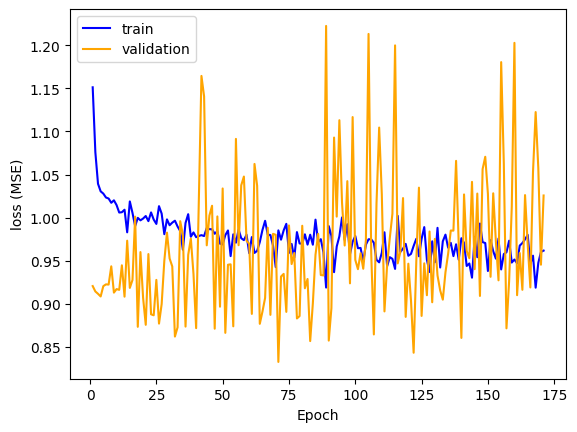

In [13]:
plt.plot(epochs, train_losses, color="blue", label="train")
plt.plot(epochs, val_losses, color="orange", label="validation")
plt.xlabel("Epoch")
plt.ylabel("loss (MSE)")
plt.legend()
plt.show()

In [14]:
# inference MSE score
model_displacement.eval().cpu()

def denorm_y(y_norm, scaler=scaler_y) :
    y_shape = y_norm.shape
    y_transformed = y_norm.reshape(y_norm.shape[0],-1)
    y_denorm = scaler.inverse_transform(y_transformed)
    y_denorm = y_denorm.reshape(y_shape)

    return y_denorm

with torch.no_grad():  
    y_pred = model_displacement(X_test)

mse_loss = nn.MSELoss()
mse_normed = mse_loss(y_pred, y_test)

y_pred_denorm = torch.from_numpy(denorm_y(y_pred))
y_test_denorm = torch.from_numpy(denorm_y(y_test))
mse_denorm = mse_loss(y_pred_denorm, y_test_denorm)

print(f"normed MSE: {mse_normed.item():.4f}")

print(f"denormed MSE: {mse_denorm.item():.4f}")

normed MSE: 0.9776
denormed MSE: 423.5542


torch.Size([10, 24, 24])
(5, 24, 24)


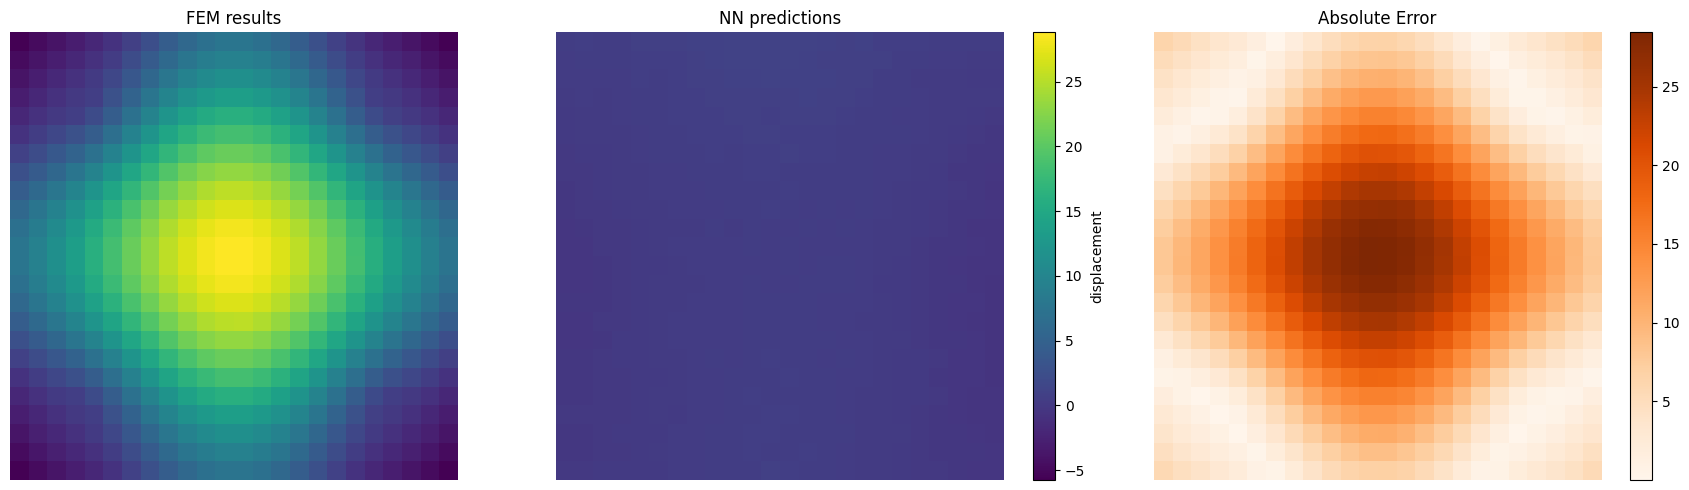

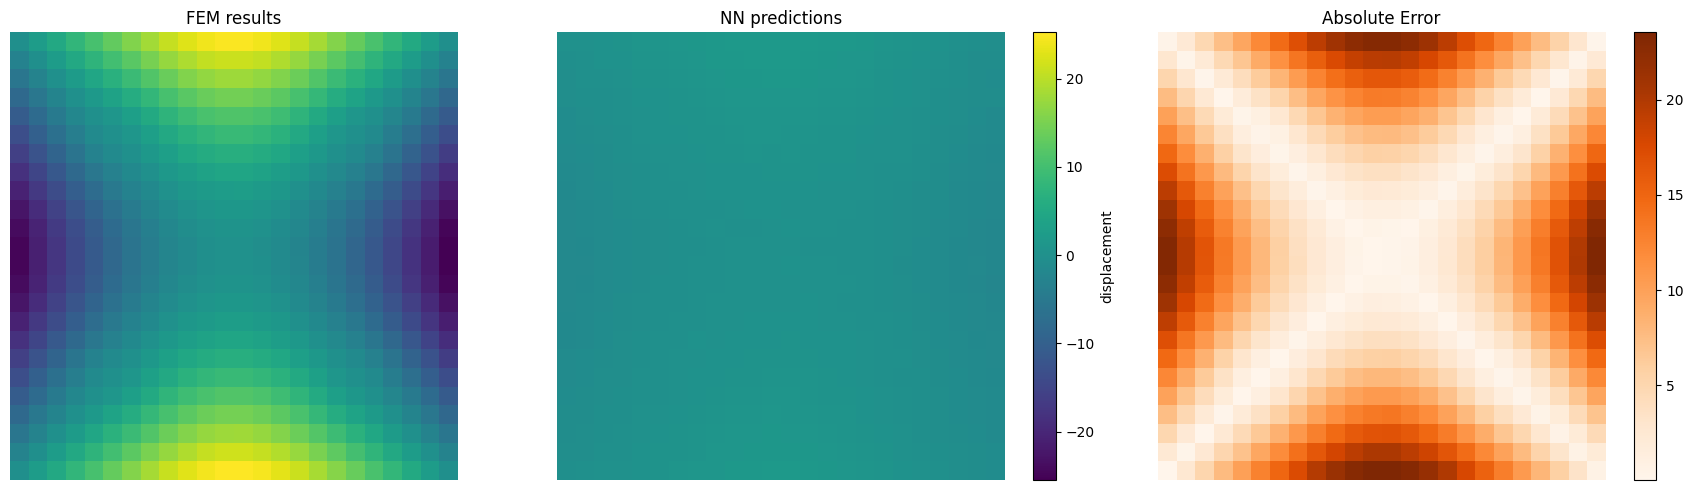

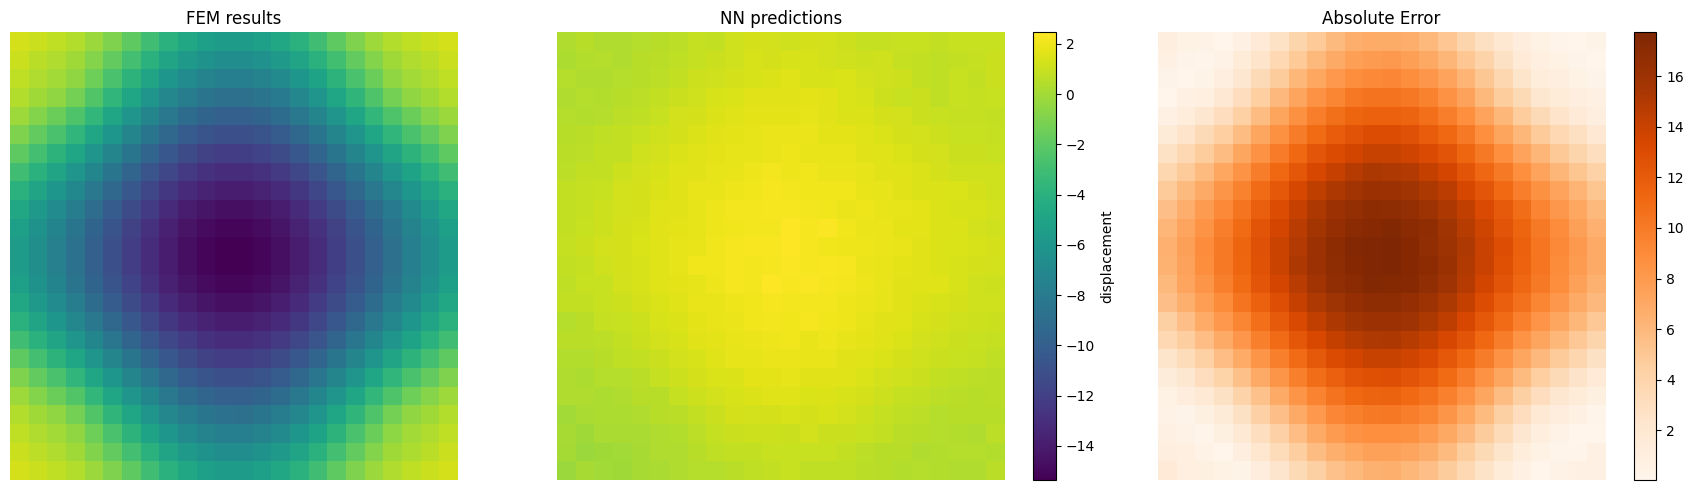

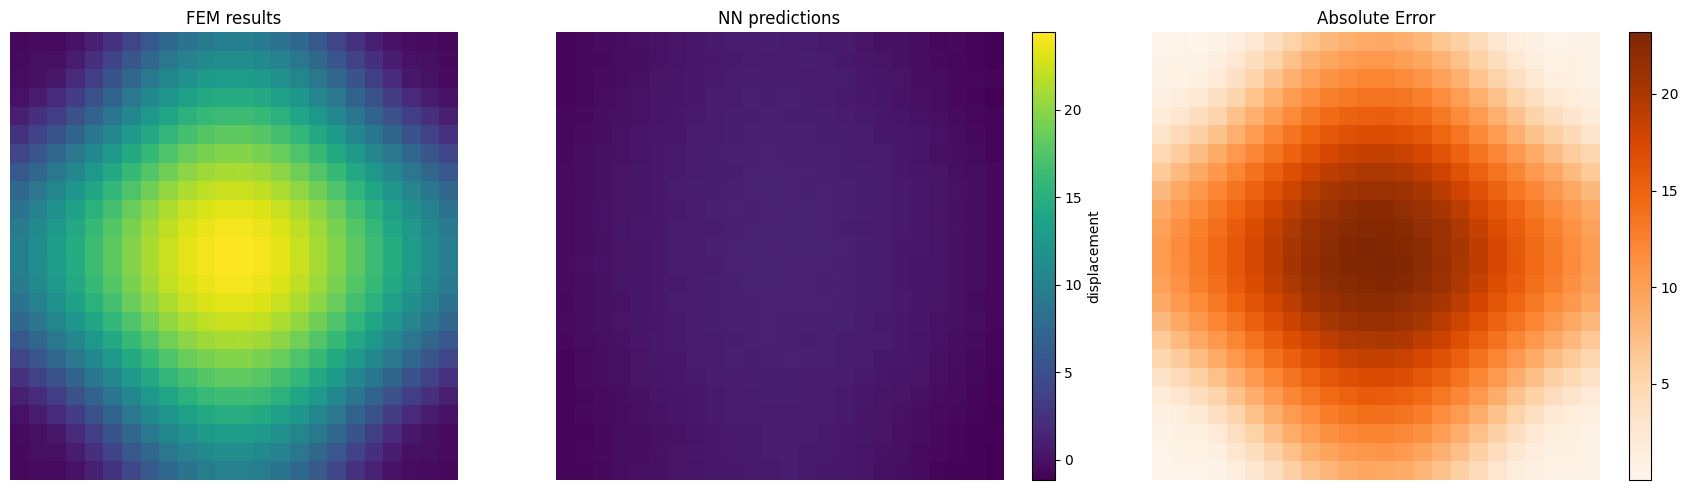

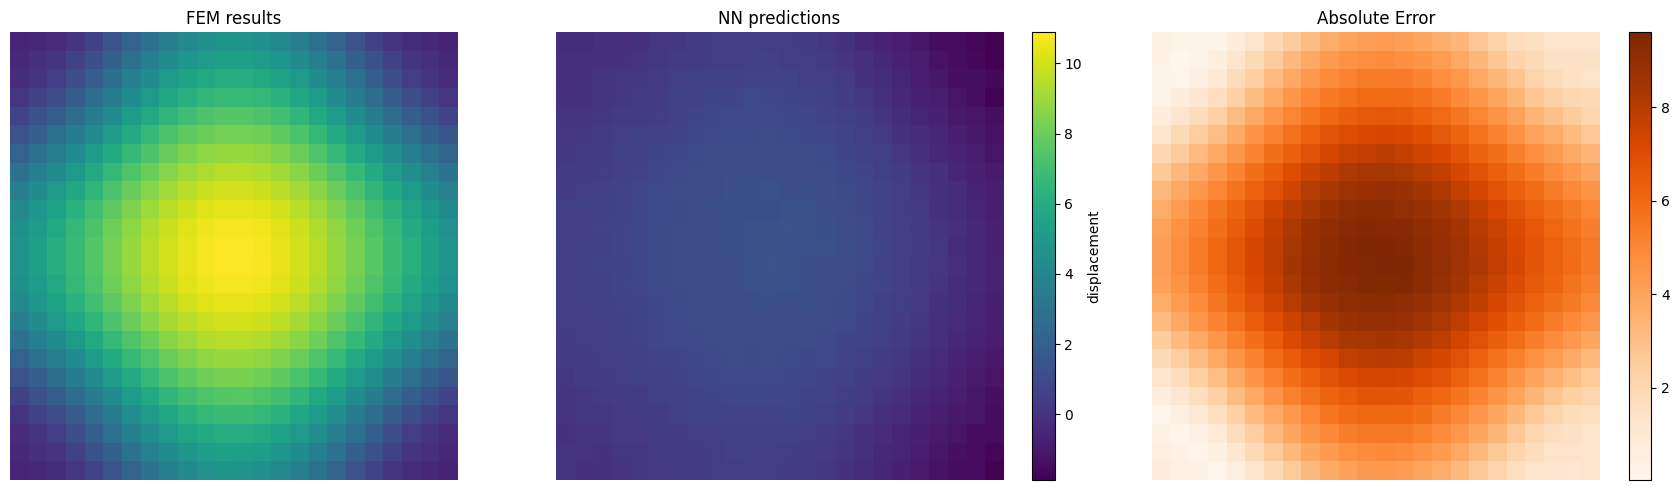

In [15]:
#visualisation inference
map_count = 5
with torch.no_grad():  
    X_test_sample = X_test[:map_count]
    X_test_sample = X_test_sample
    pred_sample = model_displacement(X_test_sample)


#pred = np.squeeze(pred.numpy(), axis=0)
pred_sample = pred_sample.numpy()
true_sample = y_test[:map_count].numpy()
print(pred.shape)
print(true_sample.shape)




pred_denorm = denorm_y(pred_sample)
true_denorm = denorm_y(true_sample)

for i in range(pred_denorm.shape[0]):
    heatmaps_from_one_sample(true_denorm[i], pred_denorm[i])
